In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [21]:
from pathlib import Path
import shutil
import os

In [47]:
os.chdir('/home/daniel/code/DATA_CHALLENGE2/CSV')
content = Path.iterdir(Path.cwd())

In [48]:
for file in content:
    old_filename = file.name
    if 'olist_' in old_filename:
        new_filename = old_filename.replace('olist_', '').replace('_dataset', '')
        shutil.move(old_filename, new_filename)

In [49]:
content = Path.iterdir(Path.cwd())

In [50]:
dataframes = {}
for file in content:
    if file.is_file():
        dataframes[file.stem] = pd.read_csv(file.name)

In [51]:
print(*dataframes.keys(), sep='\n')

sellers
order_items
order_reviews
order_payments
orders
products
geolocation
customers
product_category_name_translation


# Dataframe shapes

In [77]:
for name, df  in dataframes.items():
    print(f'{name}. Shape: {df.shape}')

sellers. Shape: (3095, 4)
order_items. Shape: (112650, 7)
order_reviews. Shape: (100000, 7)
order_payments. Shape: (103886, 5)
orders. Shape: (99441, 8)
products. Shape: (32951, 9)
geolocation. Shape: (1000163, 5)
customers. Shape: (99441, 5)
product_category_name_translation. Shape: (71, 2)


In [ ]:
# #df1 = dataframes['customers'][:100]
# #df2 = dataframes['geolocation'][:100]
# df_customers = dataframes['customers'].merge(dataframes['geolocation'], left_on='customer_city', right_on='geolocation_city')
# #df_customers = df1.merge(df2, left_on='customer_city', right_on='geolocation_city')

In [76]:
# df1 = dataframes['customers'][:100]
# df2 = dataframes['geolocation'][:100]
# df_customers = df1.merge(df2, left_on='customer_city', right_on='geolocation_city')

## 1: What is the total revenue generated by Olist, and how has it changed over time?

In [82]:
df_payments = dataframes['order_payments']
df_orders = dataframes['orders']

### Orders dataframe contains dates. Let's check if the dtype is correct

In [95]:
df_orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [99]:
date_cols = 'order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date'.split(', ')
date_cols

['order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date']

In [100]:
for col in date_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])

In [101]:
df_orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [192]:
df_orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [193]:
df_orders.sample(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
45456,1b4f6e77a7bfc8aaecb66219bac6b9eb,fb5c13a43eab0c123ae49f226709b74a,delivered,2018-07-16 22:59:19,2018-07-17 21:35:15,2018-07-20 14:43:00,2018-08-07 16:26:38,2018-08-22
77643,e8d6e91dd3d56ab5e56777ea094760ec,c15928f7d673b005bb6e2363995f822b,delivered,2018-05-18 11:43:09,2018-05-19 02:58:40,2018-05-23 15:28:00,2018-05-25 19:17:38,2018-05-30
34711,b13a6349dc3ffd0d949a6e03cf5c5aea,bed634711aadd752f21d3bd8b2dcd9c1,delivered,2017-09-27 22:17:38,2017-09-27 22:28:22,2017-09-29 19:13:58,2017-10-06 19:30:02,2017-10-26
69767,03f51c9adce893f63936c5146701aa2f,36f565da5dace4bd09fa635892eb5fe5,delivered,2018-06-17 11:03:15,2018-06-18 17:20:26,2018-06-19 12:59:00,2018-06-28 20:17:06,2018-07-24
29355,023aa4b0585594124bc50e55e0e11a5f,678c7714cdd189c7aca5cd7e6c70fb94,delivered,2018-04-01 23:03:34,2018-04-03 05:48:29,2018-04-04 21:57:32,2018-04-09 11:46:41,2018-04-18


Merge the datasets to get both order amount and date purchased

In [102]:
df = df_orders.merge(df_payments, on='order_id')

In [103]:
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value'],
      dtype='object')

In [104]:
total_revenue = df.payment_value.sum()

## Working with purchase dates

In [121]:
dates = df.order_approved_at.dt.date
dates = dates[dates.notnull()]

In [122]:
dates.min()

datetime.date(2016, 10, 4)

In [123]:
dates.max()

datetime.date(2018, 9, 3)

The oldest order was made on 2016 and the latest on 2018.

I will aggregate the orders by quarters.

In [164]:
quarterly_orders = df.set_index('order_approved_at')

In [171]:
quarter_total_revenues = quarterly_orders.resample('3M', closed='left').payment_value.sum().to_frame()

In [ ]:
# annual_revenue = (df[['order_approved_at', 'payment_value']]
#  .groupby(
#          df['order_approved_at'].apply(lambda x : x.year))
#  .sum('payment_value')
# )

In [ ]:
# annual_revenue.index = [int(i) for i in annual_revenue.index]
# annual_revenue.index.name = 'year'
# annual_revenue = annual_revenue.rename(columns = {'payment_value' : 'total_revenue'})

In [172]:
quarter_total_revenues = quarter_total_revenues.rename(columns = {'payment_value' : 'total_revenue'})
quarter_total_revenues.index.name = 'quarter_date'

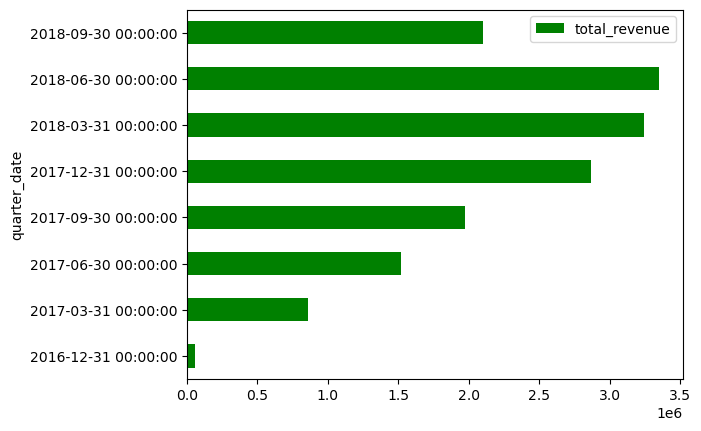

In [189]:
quarter_total_revenues.plot.barh(color='green')
plt.show()

## 2: How many orders were placed on Olist, and how does this vary by month or season?

In [203]:
valid_orders = df_orders[df_orders['order_status'] != 'canceled']

Number of orders placed by Olist:

In [205]:
valid_orders.order_id.count()

98816

In [206]:
df2 = valid_orders.set_index('order_approved_at')

In [210]:
orders_placed_monthly = df2.resample('M', closed='left').order_id.count()

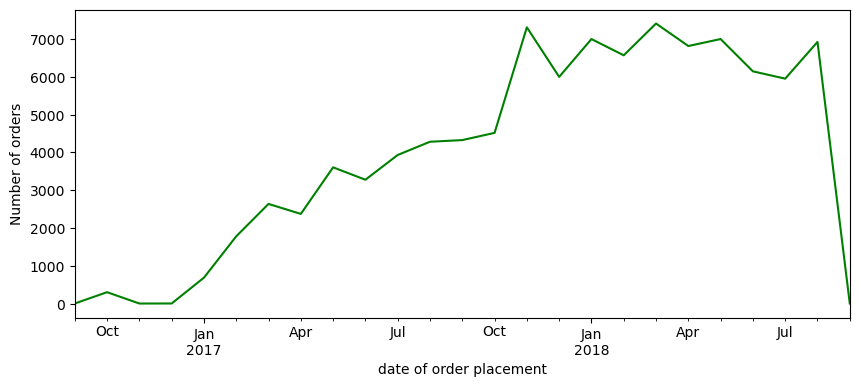

In [216]:
fig, ax = plt.subplots(figsize=(10,4))
orders_placed_monthly.plot.line(ax=ax, color='green')
ax.set_xlabel('date of order placement')
ax.set_ylabel('Number of orders')
plt.show()